Setting up your Colab environment

In [1]:
# Run these in the first cell
!pip install pandas matplotlib seaborn scikit-learn

Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


Data Preprocessing

In [7]:
# STEP 1: Load CSV and preprocess

import pandas as pd

# Load the uploaded CSV file (update path if needed)
df = pd.read_csv('/content/db_building_A.csv')

# Convert DATE to datetime and set as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

df = df.sort_index().fillna(method='ffill')

# Create time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Create lag features (past energy values)
for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
    df[f'lag_{lag}'] = df['ENERGY'].shift(lag)

# Drop rows with missing lag features
df.dropna(inplace=True)

# Preview
df.head()


<ipython-input-7-3009399344>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.sort_index().fillna(method='ffill')


,ENERGY,HDD18_3,CDD0,CDD10,PRECTOT,RH2M,T2M,T2M_MIN,T2M_MAX,ALLSKY,HOLIDAY,hour,dayofweek,month,lag_1,lag_24,lag_168
DATE,,,,,,,,,,,,,,,,,
2016-01-08 01:00:00,133.645,8.16,10.14,0.14,9.61,90.28,10.13,8.08,12.2,0.96,0,1,4,1,130.526,120.027,113.415
2016-01-08 02:00:00,135.460,8.16,10.14,0.14,9.61,90.28,10.13,8.08,12.2,0.96,0,2,4,1,133.645,122.728,112.431
2016-01-08 03:00:00,137.595,8.16,10.14,0.14,9.61,90.28,10.13,8.08,12.2,0.96,0,3,4,1,135.460,128.337,111.517
2016-01-08 04:00:00,143.414,8.16,10.14,0.14,9.61,90.28,10.13,8.08,12.2,0.96,0,4,4,1,137.595,131.244,117.240
2016-01-08 05:00:00,152.849,8.16,10.14,0.14,9.61,90.28,10.13,8.08,12.2,0.96,0,5,4,1,143.414,146.362,114.948


Train - Test Split

In [8]:
# Split based on date (last 30 days as test)
cutoff = df.index.max() - pd.Timedelta(days=30)
train = df[df.index <= cutoff]
test = df[df.index > cutoff]

features = ['hour', 'dayofweek', 'month', 'HDD18_3', 'CDD0', 'CDD10', 'PRECTOT',
            'RH2M', 'T2M', 'T2M_MIN', 'T2M_MAX', 'ALLSKY', 'HOLIDAY',
            'lag_1', 'lag_24', 'lag_168']
target = 'ENERGY'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


Model Traning and Evaluation

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict
pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 9.13
RMSE: 15.17


Visualization

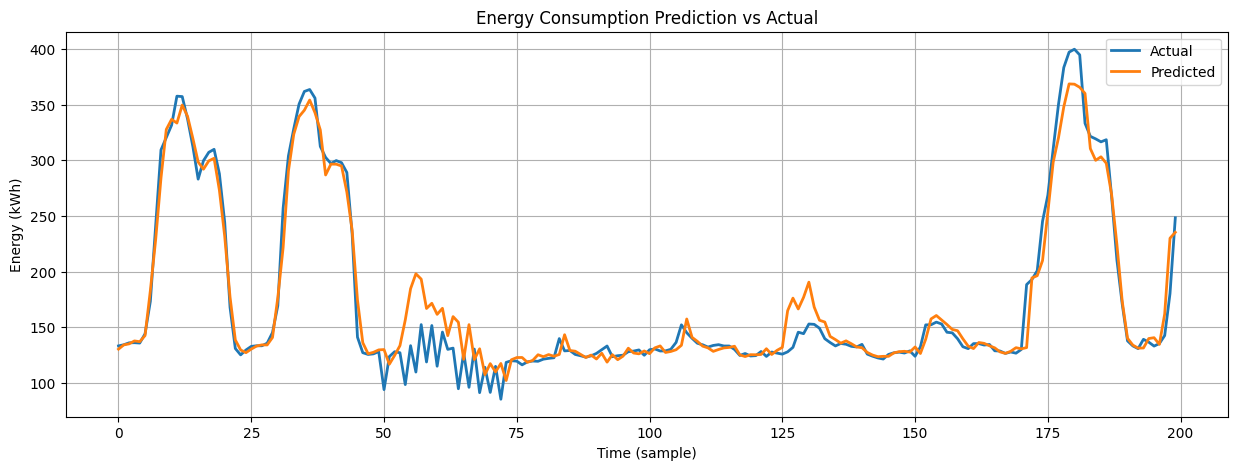

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:200], label='Actual', linewidth=2)
plt.plot(pred[:200], label='Predicted', linewidth=2)
plt.legend()
plt.title('Energy Consumption Prediction vs Actual')
plt.xlabel('Time (sample)')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.show()


Feature Importance Plot

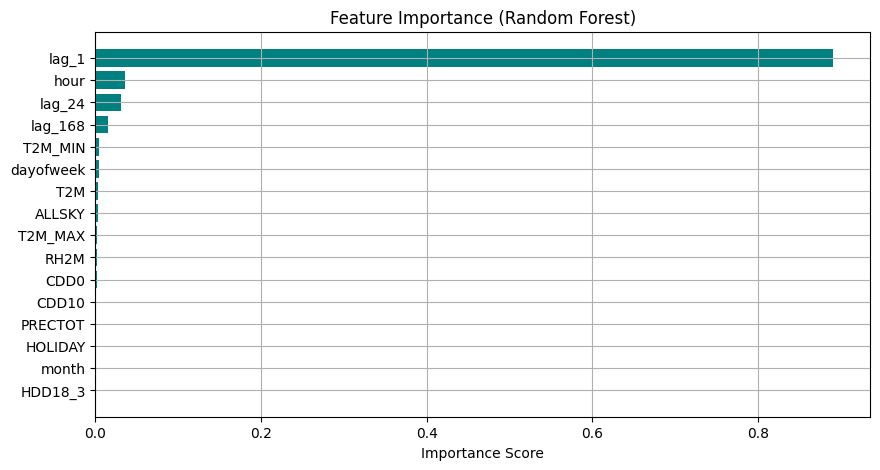

In [11]:
import pandas as pd

importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.grid(True)
plt.show()


Error Distribution Histogram

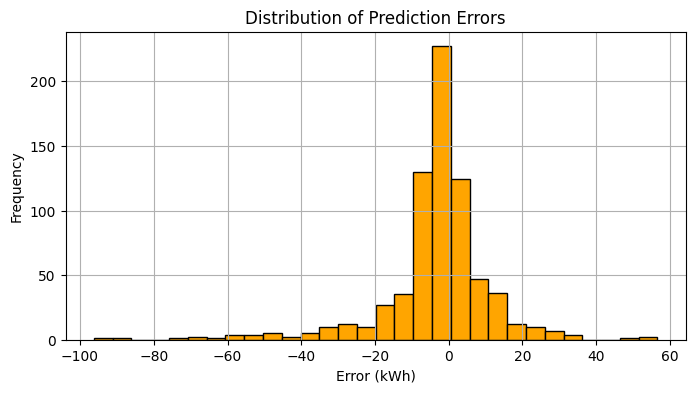

In [12]:
errors = y_test - pred

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, color='orange', edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (kWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Scatter Plot of Actual vs Predicted

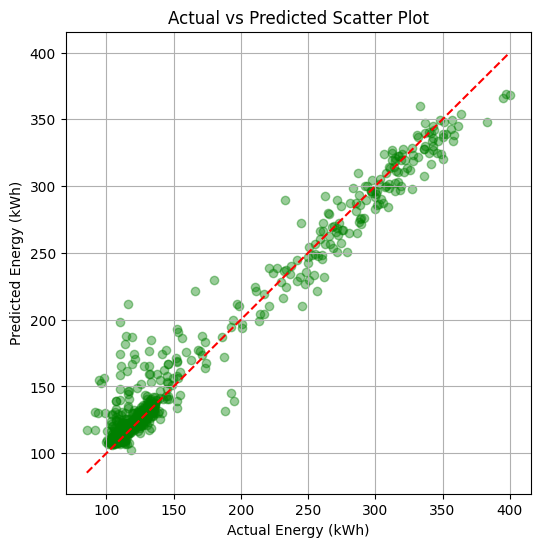

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred, alpha=0.4, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy (kWh)')
plt.ylabel('Predicted Energy (kWh)')
plt.title('Actual vs Predicted Scatter Plot')
plt.grid(True)
plt.show()
